In [5]:
#!pip install torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Autoencoder for dimensionality reduction using `pytorch`
We will test our model on peripheral blood mononuclear cells(PBMCs) single-cell gene expression dataset.

## Read in the data
Read in the PBMCs data that we will use for the training. 

In [7]:
expr_ctrl = pd.read_csv("counts_PBMC.csv",sep = ",", index_col = 0).values
anno_ctrl = pd.read_csv("celltypes_PBMC.txt", sep = "\t", header = None)
expr_ctrl = StandardScaler().fit_transform(expr_ctrl)

# Here we first reduce the dimension with PCA to speed up the training process
expr_ctrl = PCA(n_components = 100).fit_transform(expr_ctrl)
expr_ctrl = torch.FloatTensor(expr_ctrl)

## Create layers
The autoencoder that we use for biological dataset, e.g. single-cell dataset, is built upon multiple fully connected layers(fc layer). So our first step is to create our own fully connected layer from scratch.

In [9]:
class fc_layer(nn.Module):
    def __init__(self, input_size, output_size, activation = nn.ReLU()):
        """\
          Parameters:
          ----------
          input_size: input dimension of fully connected layers
          output_size: output dimension of fully connected layers
          activation: activation function, default nn.ReLU()
        """
        super(fc_layer, self).__init__()

        # weight matrix of the fully connected layer
        self.weight =  nn.Parameter(torch.empty(input_size,output_size))

        # bias of the fully connected layer
        self.bias =  nn.Parameter(torch.empty(output_size,1))

        # activation function of the fully connected layer
        self.activation = activation
        
        # initialize the parameters of weight and bias
        torch.nn.init.xavier_uniform_(self.weight)
        torch.nn.init.xavier_uniform_(self.bias)


    def forward(self, x):
        """\
          x: input data
        """
        output = torch.matmul(self.weight.t(),x)+self.bias
        # call the activation function is there is one, you don't need to revise anything here
        if self.activation is not None:
          output = self.activation(output)
        return output



In [10]:
# The first hidden layer has the input dimension the same as the number of genes in the single-cell dataset,
# the output dimension will be set as 128, relu will be used as the activation function. 
# =========================================
# Code for hidden_layer1 
# =========================================
hidden_layer1 = fc_layer(input_size=100, output_size=128)

# The second hidden layer has the input dimension = 128, and the output dimension = 2. 
# No activation function will be used here.
hidden_layer2 = fc_layer(input_size=128, output_size=2, activation=None)

# The third hidden layer has the input dimension = 2, and the output dimension = 128. 
hidden_layer3 = fc_layer(input_size=2, output_size=128)

# The output layer has the input dimension = 128, and the output dimension = number of genes. 
output =  fc_layer(input_size=128, output_size=100, activation = None)


## Assemble the autoencoder

In [28]:
# Create the model using nn.Sequential

autoencoder = nn.Sequential(
    hidden_layer1,
    hidden_layer2,
    hidden_layer3,
    output
)

In [29]:
#Print the structure of the model out with print function
print(autoencoder)

Sequential(
  (0): fc_layer(
    (activation): ReLU()
  )
  (1): fc_layer()
  (2): fc_layer(
    (activation): ReLU()
  )
  (3): fc_layer()
)


## Define the optimizer
Gradient descent algorithm will be used to train the parameters of the autoencoder. After creating the autoencoder, we need to define the **optimizer**(can be considered as the gradient descent algorithm) for the model. 

`PyTorch` provides a number of different optimizers for us to choose from, such as `optim.SGD`, `optim.RMSprop`, `optim.Adagrad` and `optim.Adam`. Here we will use stochastic gradient descent(`optim.SGD`) for the optimization. 


In [30]:
# Learning rate for the optimizer is a key hyperparameter to play around with when we need to train the model.

learning_rate = 0.0090

optimizer = optim.SGD(autoencoder.parameters(), lr=learning_rate)


## Construct loss function

In [31]:
loss_fcn = nn.MSELoss()

## Train the autoencoder

In [32]:
def train_model(model, optimizer, loss_fcn, n_epochs=10):

    batch_size=100
    losses = []

    # we'll train the network for 10 epochs
    step = 0
    for epoch in range(n_epochs):
        # randomize the order of the data each time through
        random_order = np.random.permutation(expr_ctrl.shape[0])
        data_randomized = expr_ctrl[random_order]

        # train the network on batches of size `batch_size`
        for data_batch in np.array_split(data_randomized, data_randomized.shape[0] // batch_size):
            step += 1

            # update the network weights to minimize the loss
            output = model(data_batch)

            # get loss
            loss = loss_fcn(output, data_batch)

            # print the loss every 100 epochs
            if step % 100 == 0:
                print("Step: {} Loss: {:.3f}".format(step, loss.item()))

            # backpropagate the loss
            loss.backward()

            # update parameters
            optimizer.step()

            # reset gradients
            optimizer.zero_grad()
            losses.append(loss)

    return losses

In [33]:
losses = train_model(autoencoder, optimizer = optimizer, loss_fcn = loss_fcn, n_epochs = 50)

Step: 100 Loss: 4.281
Step: 200 Loss: 3.873
Step: 300 Loss: 5.124
Step: 400 Loss: 6.014
Step: 500 Loss: 5.931
Step: 600 Loss: 5.002
Step: 700 Loss: 4.620
Step: 800 Loss: 5.355
Step: 900 Loss: 5.068
Step: 1000 Loss: 5.188
Step: 1100 Loss: 4.556
Step: 1200 Loss: 5.289
Step: 1300 Loss: 4.876
Step: 1400 Loss: 5.413
Step: 1500 Loss: 5.559


## Plot the latent embedding
After training the autoencoder, we need to extract the latent embedding that it generates, which correspond to the output of the encoder. 

In [35]:
# Get the output of the encoder(latent embedding) and visualize it with a scatter plot
with torch.no_grad():
    ae_coordinates = autoencoder[1].forward(autoencoder[0].forward(expr_ctrl.t())).t()

AE.pdf


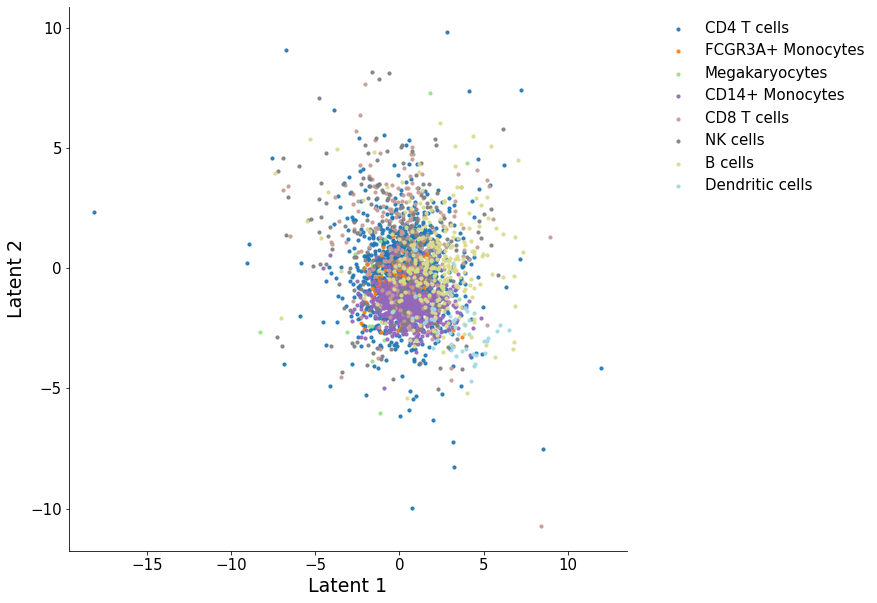

In [36]:
def plot_latent(z, anno, save = None, figsize = (10,10), axis_label = "Latent", **kwargs):
    _kwargs = {
        "s": 10,
        "alpha": 0.9,
    }
    _kwargs.update(kwargs)

    fig = plt.figure(figsize = figsize)
    ax = fig.add_subplot()
    cluster_types = set([x for x in np.unique(anno)])
    colormap = plt.cm.get_cmap("tab20", len(cluster_types))

    for i, cluster_type in enumerate(cluster_types):
        index = np.where(anno == cluster_type)[0]
        ax.scatter(z[index,0], z[index,1], color = colormap(i), label = cluster_type, **_kwargs)
    
    ax.legend(loc='upper left', prop={'size': 15}, frameon = False, ncol = 1, bbox_to_anchor=(1.04, 1))
    
    ax.tick_params(axis = "both", which = "major", labelsize = 15)

    ax.set_xlabel(axis_label + " 1", fontsize = 19)
    ax.set_ylabel(axis_label + " 2", fontsize = 19)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)  
    
    if save:
        fig.savefig(save, bbox_inches = "tight")
    
    print(save)



plot_latent(ae_coordinates, anno_ctrl, axis_label = "Latent", save = "AE.pdf")

## Implement autoencoder using nn.Linear

In [37]:
class autoencoder(nn.Module):
    def __init__(self, in_features):
        super(autoencoder,self).__init__()
        #Code for hidden_layer1, hidden_layer2, hidden_layer3, output
        self.hidden_layer1 = nn.Linear(100, 128)
        self.hidden_layer2 = nn.Linear(128,2)
        self.hidden_layer3 = nn.Linear(2,128)
        self.output = nn.Linear(128,100)
    def forward(self, x):
        # Code for forward pass
        embed = F.relu(self.hidden_layer2(F.relu(self.hidden_layer1(x))))

        # output is the output of the decoder
        output = F.relu(self.output(F.relu(self.hidden_layer3(embed))))

        return output 

In [38]:
ae = autoencoder(in_features = expr_ctrl.shape[1])
optimizer = optim.SGD(ae.parameters(), lr=learning_rate)
losses = train_model(ae, optimizer = optimizer, loss_fcn = loss_fcn, n_epochs = 100)

Step: 100 Loss: 5.912
Step: 200 Loss: 5.760
Step: 300 Loss: 6.220
Step: 400 Loss: 6.109
Step: 500 Loss: 4.814
Step: 600 Loss: 5.373
Step: 700 Loss: 4.537
Step: 800 Loss: 3.433
Step: 900 Loss: 4.630
Step: 1000 Loss: 6.135
Step: 1100 Loss: 5.445
Step: 1200 Loss: 5.138
Step: 1300 Loss: 6.358
Step: 1400 Loss: 4.013
Step: 1500 Loss: 5.795
Step: 1600 Loss: 4.795
Step: 1700 Loss: 4.672
Step: 1800 Loss: 4.584
Step: 1900 Loss: 5.462
Step: 2000 Loss: 5.112
Step: 2100 Loss: 5.009
Step: 2200 Loss: 5.187
Step: 2300 Loss: 4.503
Step: 2400 Loss: 5.860
Step: 2500 Loss: 5.280
Step: 2600 Loss: 4.580
Step: 2700 Loss: 5.577
Step: 2800 Loss: 4.088
Step: 2900 Loss: 5.995
Step: 3000 Loss: 5.323


AE2.pdf


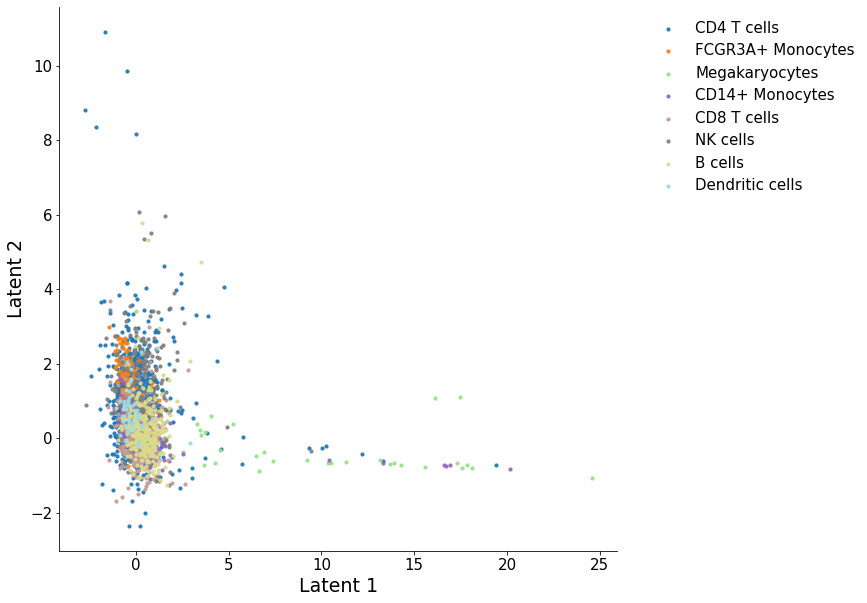

In [39]:
# Get the output of the encoder(latent embedding) and visualize it with a scatter plot
with torch.no_grad():

    ae_coordinates = ae.hidden_layer2(F.relu(ae.hidden_layer1(expr_ctrl)))

plot_latent(ae_coordinates, anno_ctrl, axis_label = "Latent", save = "AE2.pdf")